# Backtesting with zipline - Pipeline API with Custom Data

## Imports & Settings

In [1]:
from collections import defaultdict
from time import time
import pyfolio as pf
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission,
                         order_target, order_target_percent)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader

In [2]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

### Load zipline extensions

Only need this in notebook to find bundle.

In [3]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [4]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

In [5]:
N_LONGS = 10
N_SHORTS = 10
MIN_POSITIONS = 5

## Load Data

### Quandl Wiki Bundel

In [6]:
bundle_data = bundles.load('quandl')

### ML Predictions

In [7]:
def load_predictions(bundle):
    predictions = pd.read_hdf('../00_data/backtest.h5', 'data')[['predicted']].dropna()
    tickers = predictions.index.get_level_values(0).unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))
    return (predictions
            .unstack('ticker')
            .rename(columns=ticker_map)
            .predicted
            .tz_localize('UTC')), assets

predictions, assets = load_predictions(bundle_data)

In [8]:
predictions, assets = load_predictions(bundle_data)

### Define Custom Dataset

In [9]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = US_EQUITIES

### Define Pipeline Loaders

In [10]:
signal_loader = {SignalData.predictions:
                     DataFrameLoader(SignalData.predictions, predictions)}

## Pipeline Setup

### Custom ML Factor

In [11]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, preds):
        out[:] = preds

### Create Pipeline

In [12]:
def compute_signals():
    signals = MLSignal()
#     predictions = SignalData.predictions.latest
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS, mask=signals > 0),
        'shorts': signals.bottom(N_SHORTS, mask=signals < 0)},
            screen=StaticAssets(assets)
    )

## Initialize Algorithm

In [13]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.n_shorts = N_SHORTS
    context.min_positions = MIN_POSITIONS
    context.universe = assets

    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0, min_trade_cost=0))

    schedule_function(rebalance,
                      date_rules.every_day(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

### Get daily Pipeline results

In [14]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    context.trades = (output['longs'].astype(int)
                      .append(output['shorts'].astype(int).mul(-1))
                      .reset_index()
                      .drop_duplicates()
                      .set_index('index')
                      .squeeze())

## Define Rebalancing Logic

In [15]:
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    trades = defaultdict(list)

    for stock, trade in context.trades.items():
        if not trade:
            order_target(stock, 0)
        else:
            trades[trade].append(stock)
    context.longs, context.shorts = len(trades[1]), len(trades[-1])
    if context.longs > context.min_positions and context.shorts > context.min_positions:
        for stock in trades[-1]:
            order_target_percent(stock, -1 / context.shorts)
        for stock in trades[1]:
            order_target_percent(stock, 1 / context.longs)

## Record Data Points

In [16]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

## Run Algorithm

In [17]:
dates = predictions.index.get_level_values('date')
start_date = dates.min()
end_date = (dates.max() + pd.DateOffset(1))

In [18]:
start_date, end_date

(Timestamp('2014-06-23 00:00:00+0000', tz='UTC'),
 Timestamp('2017-11-30 00:00:00+0000', tz='UTC'))

In [19]:
start = time()
results = run_algorithm(start=start_date,
                       end=end_date,
                       initialize=initialize,
                       before_trading_start=before_trading_start,
                       capital_base=1e6,
                       data_frequency='daily',
                       bundle='quandl',
                       custom_loader=signal_loader) # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

[2019-12-08 04:26:35.416130]: WARNING: _load_cached_data: Refusing to download new benchmark data because a download succeeded at 2019-12-08 04:23:26.396987+00:00.
[2019-12-08 04:26:35.436354]: WARNING: _load_cached_data: Refusing to download new treasury data because a download succeeded at 2019-12-08 04:23:27.204987+00:00.
[2019-12-08 04:26:58.081172]: INFO: handle_simulation_end: Simulated 869 trading days
first open: 2014-06-23 13:31:00+00:00
last close: 2017-11-30 21:00:00+00:00


Duration: 22.69s


## Performance Analysis with PyFolio

In [20]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [21]:
benchmark = web.DataReader('SP500', 'fred', '2014', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

/home/stefan/.pyenv/versions/3.5.7/envs/zip_test/lib/python3.5/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.08,2017-01-17,2017-09-08,NaT,NaN
1,6.67,2015-08-26,2015-10-08,2015-12-14,79
2,5.67,2016-05-16,2016-06-23,2016-09-20,92
3,4.53,2015-01-22,2015-04-06,2015-04-24,67
4,4.16,2016-04-25,2016-05-02,2016-05-05,9


Stress Events,mean,min,max
Oct14,-0.05%,-0.99%,0.32%
Fall2015,0.03%,-1.66%,2.89%
New Normal,0.06%,-5.05%,4.18%


Top 10 long positions of all time,max
sid,
ABBV,46.94%
NVDA,22.72%
UNH,21.35%
ADBE,21.33%
TWTR,21.24%
TSLA,20.54%
ATVI,20.34%
LMT,20.26%
UTX,20.24%


Top 10 short positions of all time,max
sid,
ABBV,-57.15%
ADBE,-31.42%
UNH,-31.36%
ISRG,-26.05%
FCX,-25.98%
QCOM,-20.87%
DVN,-20.56%
CHK,-20.23%
CVX,-20.04%


Top 10 positions of all time,max
sid,
ABBV,57.15%
ADBE,31.42%
UNH,31.36%
ISRG,26.05%
FCX,25.98%
NVDA,22.72%
TWTR,21.24%
QCOM,20.87%
DVN,20.56%


/home/stefan/.pyenv/versions/3.5.7/envs/zip_test/lib/python3.5/site-packages/pyfolio/round_trips.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/home/stefan/.pyenv/versions/3.5.7/envs/zip_test/lib/python3.5/site-packages/pyfolio/round_trips.py:83: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
/home/stefan/.pyenv/versions/3.5.7/envs/zip_test/lib/python3.5/site-packages/pyfolio/round_trips.py:86: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/home/stefan/.pyenv/versions/3.5.7/envs/zip_test/lib/python3.5/site-packages/pyfolio/round_trips.py:90: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
/home/stefan/.pyenv/versions/3.5.7/envs/zip_test/lib/python3.5/site-packages/pyfolio/round_trips.py:379: FutureW

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,12820.00,5947.00,6873.00
Percent profitable,0.51,0.50,0.52
Winning round_trips,6501.00,2951.00,3550.00
Losing round_trips,6222.00,2952.00,3270.00
Even round_trips,97.00,44.00,53.00


PnL stats,All trades,Short trades,Long trades
Total profit,$642278.07,$255747.18,$386530.89
Gross profit,$8725591.38,$4372136.53,$4353454.85
Gross loss,$-8083313.31,$-4116389.35,$-3966923.96
Profit factor,$1.08,$1.06,$1.10
Avg. trade net profit,$50.10,$43.00,$56.24
Avg. winning trade,$1342.19,$1481.58,$1226.33
Avg. losing trade,$-1299.15,$-1394.44,$-1213.13
Ratio Avg. Win:Avg. Loss,$1.03,$1.06,$1.01
Largest winning trade,$25989.60,$25989.60,$23177.06
Largest losing trade,$-41125.89,$-35642.10,$-41125.89


Duration stats,All trades,Short trades,Long trades
Avg duration,1 days 10:52:17.784555,1 days 11:06:08.656129,1 days 10:40:18.856394
Median duration,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00
Longest duration,5 days 03:00:00,5 days 03:00:00,5 days 03:00:00
Shortest duration,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.00%,0.00%,0.01%
Avg returns winning,0.09%,0.10%,0.08%
Avg returns losing,-0.09%,-0.09%,-0.08%
Median returns all round_trips,0.00%,-0.00%,0.00%
Median returns winning,0.03%,0.04%,0.03%
Median returns losing,-0.03%,-0.04%,-0.03%
Largest winning trade,2.04%,2.04%,1.69%
Largest losing trade,-2.48%,-2.34%,-2.48%


Symbol stats,AAL,AAOI,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,AGN,AIG,ALTR,ALXN,AMAT,AMBA,AMD,AMGN,AMT,AMZN,ANTM,APA,APC,APD,ARNC,ATVI,AVGO,AXP,AZO,BA,BAC,BAX,BBBY,BBY,BDX,BIDU,BIIB,BK,BMY,BP,BSX,C,CAT,CB,CBS,CCI,CELG,CHK,CHTR,CI,CL,CMCSA,CMG,CMI,CNC,COF,COP,COST,COTY,CRM,CSCO,CSX,CTL,CTSH,CVS,CVX,CXO,DAL,DDD,DE,DG,DIS,DISH,DLR,DLTR,DOW,DTV,DUK,DVN,EA,EBAY,EFX,EL,ENDP,EOG,EQIX,EQT,EW,EXC,EXPE,F,FB,FCX,FDX,FL,FLT,FOX,FOXA,FTI,GE,GILD,GM,GOOG,GOOGL,GPN,GS,HAL,HCA,HD,HES,HLF,HON,HPE,HPQ,HSY,HTZ,HUM,IBM,ILMN,INCY,INTC,IP,ISRG,JCP,JNJ,JPM,KHC,KMI,KO,KR,LB,LDOS,LL,LLY,LMT,LNG,LOW,LRCX,LUV,LVS,LYB,M,MA,MAR,MCD,MCK,MDLZ,MDT,MET,MGM,MLM,MMM,MNST,MO,MPC,MRK,MRO,MS,MSFT,MU,MYL,NEE,NEM,NFLX,NKE,NOV,NVDA,NWL,OKE,ORCL,ORLY,OXY,PANW,PCG,PEP,PFE,PG,PM,PNC,PRGO,PSX,PXD,PYPL,QCOM,RAD,RCL,REGN,RIG,SBAC,SBUX,SCHW,SDRL,SE,SHW,SIG,SLB,SPG,SPLK,SRPT,STZ,SWKS,SWN,SYF,SYY,T,TAP,TDG,TGT,TJX,TMO,TSLA,TSN,TWTR,TXN,UAA,UAL,ULTA,UNH,UNP,UPS,URI,USB,UTX,V,VLO,VRTX,VZ,WBA,WDC,WFC,WLL,WMB,WMT,WY,WYNN,X,XOM,YELP,YUM,ZTS
Avg returns all round_trips,0.03%,-0.07%,0.00%,-0.02%,-0.01%,-0.02%,0.01%,nan%,0.03%,-0.00%,-0.00%,-0.02%,0.02%,-0.01%,0.03%,-0.06%,0.03%,0.08%,-0.00%,-0.01%,-0.03%,-0.00%,0.02%,0.04%,0.01%,0.01%,-0.01%,0.00%,0.01%,0.02%,0.00%,-0.02%,0.01%,-0.01%,0.01%,0.02%,0.01%,-0.00%,-0.00%,-0.03%,0.00%,-0.02%,-0.01%,0.01%,-0.01%,0.01%,-0.03%,0.00%,-0.00%,-0.01%,0.01%,0.00%,0.03%,0.09%,0.06%,-0.01%,0.03%,0.01%,0.03%,0.02%,-0.00%,0.08%,-0.01%,0.00%,0.01%,-0.31%,-0.00%,-0.03%,0.01%,0.03%,0.00%,0.10%,0.01%,-0.00%,0.03%,0.01%,-0.05%,0.03%,-0.02%,0.01%,-0.01%,-0.01%,0.10%,-0.01%,-0.00%,0.01%,0.02%,-0.03%,-0.04%,0.03%,0.02%,0.02%,0.01%,-0.15%,0.23%,-0.04%,-0.00%,0.11%,0.00%,0.00%,-0.01%,0.01%,0.01%,0.05%,0.01%,-0.01%,0.03%,0.02%,0.24%,0.02%,0.02%,0.22%,0.11%,nan%,0.05%,0.01%,0.00%,0.01%,0.04%,-0.00%,0.13%,0.02%,-0.07%,0.01%,0.01%,0.02%,-0.02%,0.00%,0.00%,0.10%,-0.02%,-0.05%,0.01%,-0.01%,-0.07%,-0.01%,-0.00%,0.01%,0.01%,0.03%,0.00%,-0.02%,-0.00%,-0.00%,0.05%,0.01%,-0.00%,-0.02%,0.04%,0.12%,-0.01%,-0.22%,-0.00%,0.03%,-0.01%,-0.06%,0.01%,0.02%,0.01%,0.02%,0.01%,0.00%,-0.01%,-0.02%,0.03%,-0.01%,0.03%,-0.02%,0.00%,0.04%,0.01%,-0.01%,nan%,0.01%,0.02%,0.01%,-0.00%,0.00%,-0.02%,0.04%,0.00%,0.02%,-0.01%,0.05%,-0.22%,0.01%,-0.22%,-0.01%,-0.01%,-0.00%,0.00%,0.04%,-0.03%,-0.00%,-0.00%,0.02%,-0.02%,-0.05%,-0.01%,-0.02%,0.05%,-0.02%,-0.12%,-0.01%,-0.24%,0.03%,0.01%,0.01%,0.06%,-0.01%,0.03%,0.02%,-0.00%,0.01%,-0.00%,0.06%,0.00%,0.01%,0.03%,0.24%,-0.01%,0.00%,-0.01%,0.01%,0.05%,-0.01%,0.03%,0.00%,0.00%,0.04%,-0.00%,0.02%,0.06%,0.02%,0.01%,-0.01%,0.05%,0.01%,-0.17%
Avg returns winning,0.11%,0.26%,0.08%,0.08%,0.03%,0.03%,0.08%,nan%,0.08%,0.09%,0.05%,0.08%,0.13%,0.06%,0.39%,0.17%,0.08%,0.11%,0.06%,0.07%,0.08%,0.13%,0.13%,0.06%,0.09%,0.10%,0.05%,0.11%,0.07%,0.08%,0.28%,0.01%,0.05%,0.01%,0.09%,0.10%,0.03%,0.06%,0.18%,0.02%,0.05%,0.08%,0.02%,0.08%,0.02%,0.08%,0.15%,0.09%,0.08%,0.02%,0.06%,0.11%,0.03%,0.11%,0.09%,0.10%,0.07%,0.11%,0.10%,0.07%,0.07%,0.10%,0.05%,0.07%,0.07%,nan%,0.08%,0.07%,0.08%,0.09%,0.06%,0.10%,0.01%,0.03%,0.09%,0.02%,0.02%,0.24%,0.08%,0.07%,0.05%,0.01%,0.23%,0.09%,0.02%,0.05%,0.03%,0.02%,0.07%,0.07%,0.09%,0.23%,0.04%,nan%,0.49%,0.00%,0.06%,0.11%,0.06%,0.10%,0.06%,0.07%,0.08%,0.15%,0.06%,0.12%,0.07%,0.06%,0.24%,0.07%,0.08%,0.22%,0.14%,nan%,0.12%,0.12%,0.04%,0.12%,0.12%,0.06%,0.13%,0.07%,nan%,0.03%,0.06%,0.07%,0.11%,0.04%,0.06%,0.10%,0.01%,0.06%,0.09%,0.05%,0.06%,0.06%,0.09%,0.10%,0.11%,0.17%,0.08%,0.09%,0.02%,0.03%,0.16%,0.08%,0.05%,0.04%,0.06%,0.12%,0.04%,nan%,0.05%,0.11%,0.05%,0.16%,0.09%,0.09%,0.13%,0.14%,0.04%,0.15%,0.10%,0.08%,0.17%,0.12%,0.05%,0.02%,0.04%,0.11%,0.07%,0.06%,nan%,0.04%,0.09%,0.06%,0.04%,0.08%,0.07%,0.14%,0.10%,0.09%,0.06%,0.06%,0.01%,0.12%,0.06%,0.00%,0.06%,0.09%,0.02%,0.09%,nan%,0.33%,0.07%,0.04%,nan%,0.07%,0.09%,0.08%,0.44%,0.04%,nan%,0.04%,nan%,0.08%,0.05%,0.04%,0.11%,0.10%,0.06%,0.13%,0.06%,0.12%,0.08%,0.12%,0.05%,0.06%,0.11%,0.24%,0.03%,0.08%,0.06%,0.09%,0.19%,0.04%,0.08%,0.11%,0.07%,0.48%,0.14%,0.07%,0.06%,0.11%,0.16%,0.05%,0.17%,0.08%,nan%
Avg retur

Profitability (PnL / PnL total) per name,
symbol,
FCX,13.47%
TWTR,12.51%
BIIB,9.32%
AAL,9.31%
WYNN,7.70%
REGN,6.43%
AMGN,6.16%
MU,5.34%
ALXN,5.15%


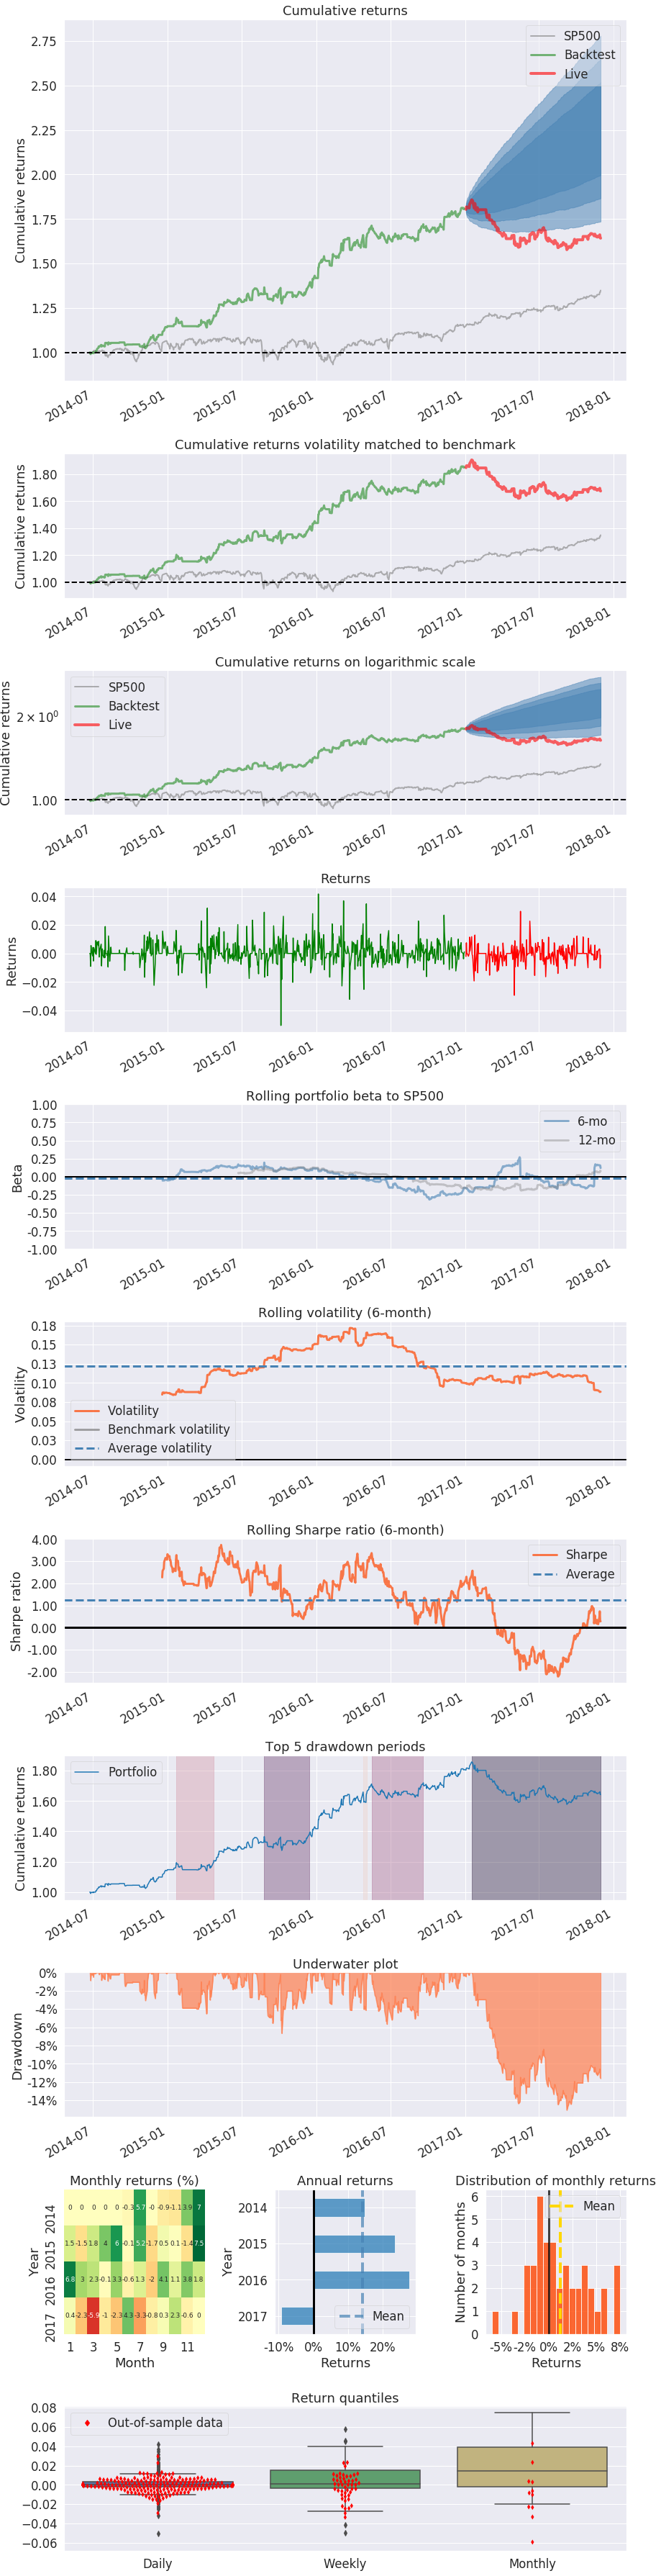

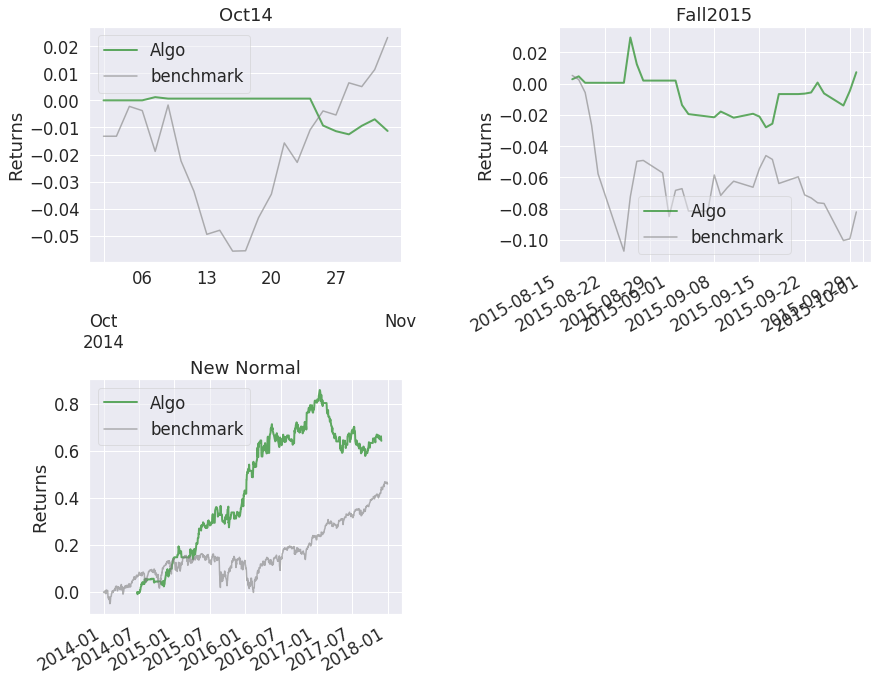

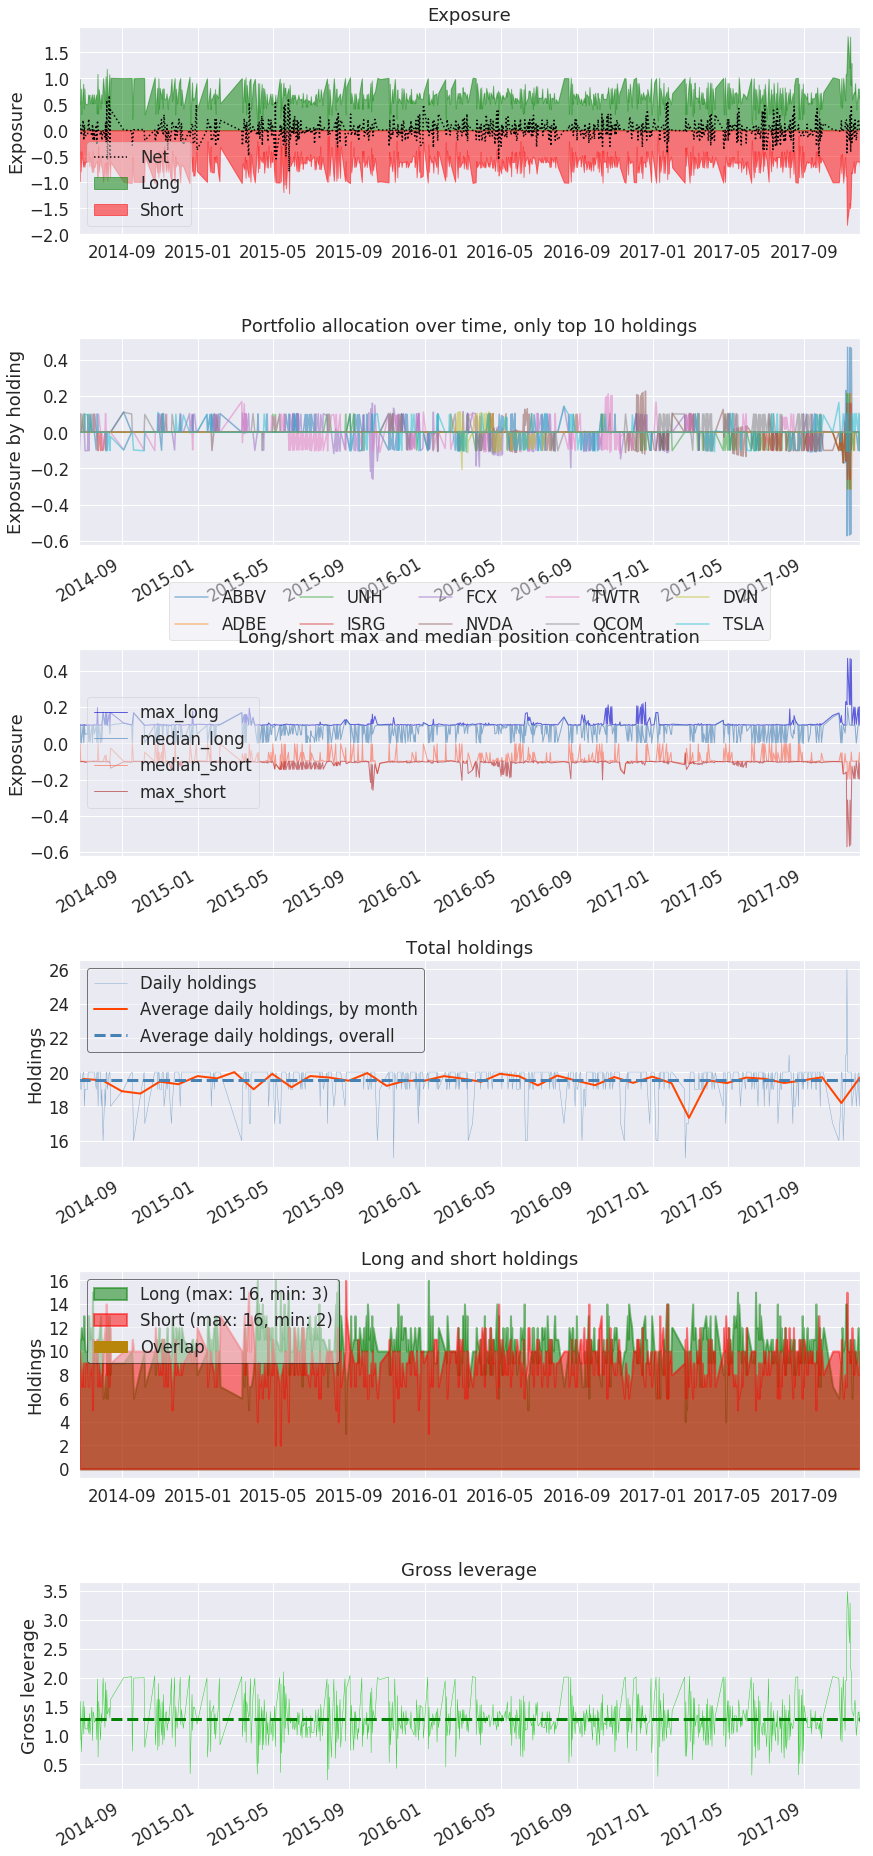

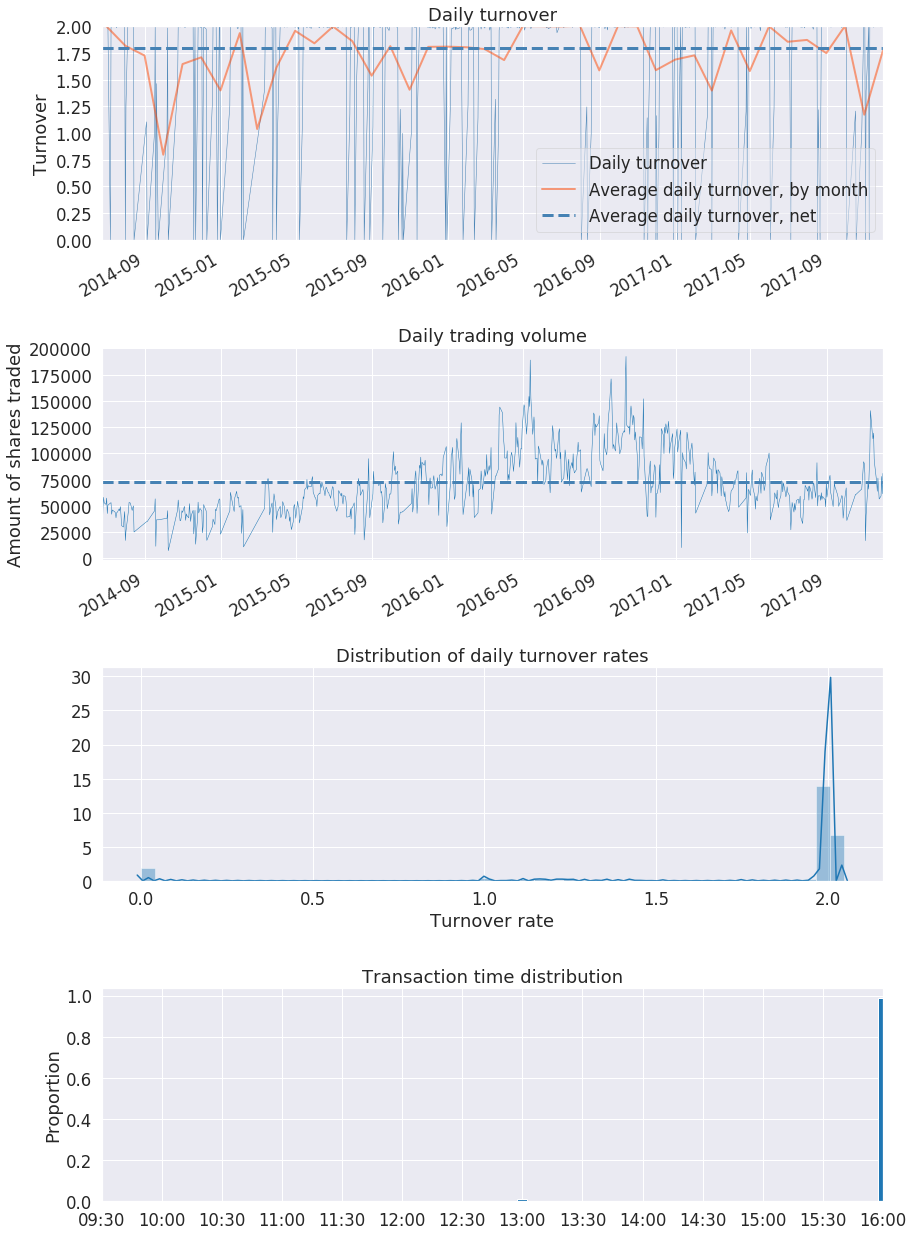

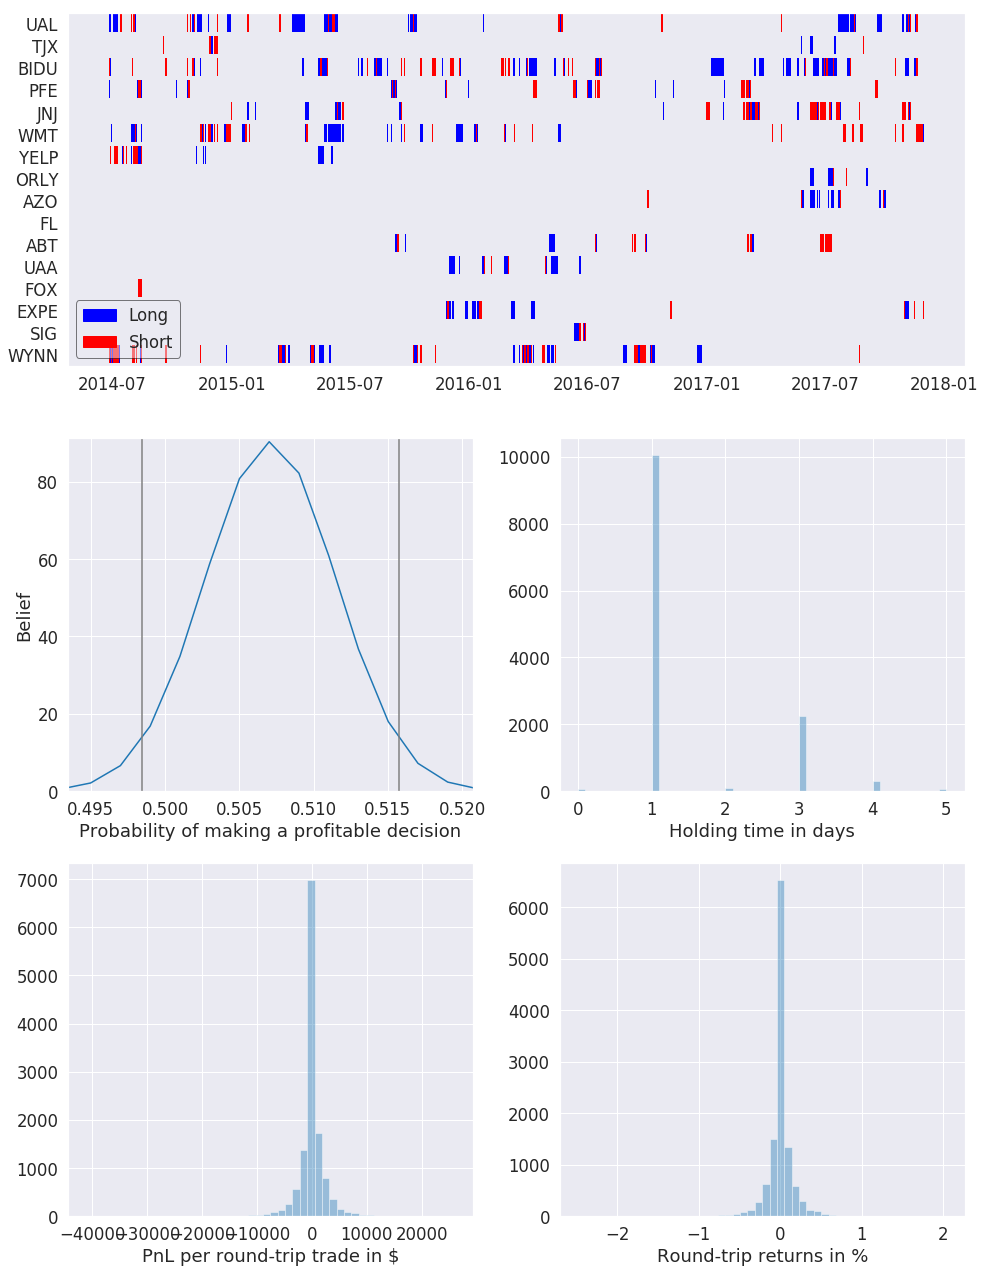

In [22]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date='2017-01-01', 
                          round_trips=True)